In [2]:
from fastai.text import *
path =Path('/home/ubuntu/fastai2/fastai/courses/dl2/imdb_scripts') #path to where the dataset is

In [3]:
from fastai.callbacks import * 

In [5]:
import spacy
spacy.load('es_core_news_sm')

In [6]:
ttok=Tokenizer(lang='es')

In [7]:
import html
import fire
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

re1 = re.compile(r'  +')


def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


def get_texts(df, n_lbls, lang='en'):
    if len(df.columns) == 1:
        labels = []
        texts = f'\n{BOS} {FLD} 1 ' + df[0].astype(str)
    else:
        labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
        texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
        for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls+1} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer(lang='es').process_all(partition_by_cores(texts,n_cpus=10000))
    return tok, list(labels)

"""
def get_all(df, n_lbls, lang='en'):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls, lang=lang)
        tok += tok_
        labels += labels_
    return tok, labels
"""
def get_all(df, n_lbls, lang='en'):
    tok, labels = [], []
    tok, labels = get_texts(df, n_lbls, lang=lang)
    return tok, labels

In [8]:
df_trn = pd.read_csv(path / 'train.csv', header=None, sep='\t')
df_val = pd.read_csv(path / 'val.csv', header=None, sep='\t')

In [37]:
df_trn.columns

Int64Index([0, 1], dtype='int64')

In [41]:
tmp_path = path / 'tmp2'
tmp_path.mkdir(exist_ok=True)
tok_trn, trn_labels = get_all(df_trn, 1, lang='es_core_news_sm')
tok_val, val_labels = get_all(df_val, 1, lang='es_core_news_sm')

In [52]:
df_trn.head()

,0,1
0,0,Eslinga Std Plana Amarilla Cs/6 3 Tn X 2.5 Mts
1,0,"Rodillera Con Barras Laterales, Unica Con Esta..."
2,1,Batería Lth Jet Ski Arctic Cat Tiger Shark 200...
3,0,Mecha Sds Plus Venturo 6x160
4,0,Kit Reparo Parcial Trambulador Corsa Meriva Mo...


In [13]:
tmp_path = path / 'tmp2'

In [10]:
min_freq=2
max_vocab=60000
freq = Counter(p for o in tok_trn for p in o)
print(freq.most_common(25))

[('xxmaj', 1568898), ("'", 500427), ('1', 266528), ('\n ', 250872), ('xbos', 250872), ('xfld', 250872), (',', 182127), (']', 85788), ('[', 85787), ('de', 70381), ('-', 52783), ('/', 37035), ('xxup', 28065), ('bateria', 27549), ('para', 26738), ('batería', 19101), ('+', 16412), ('gas', 14938), ('kit', 13911), ('(', 13167), ('moto', 13072), ('2', 12608), ('lth', 12216), (')', 12147), ('c', 11169)]


In [11]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
print(len(itos))

40372


In [12]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [13]:
np.save(tmp_path / 'trn_ids.npy', trn_lm)
np.save(tmp_path / 'val_ids.npy', val_lm)
np.save(tmp_path / 'lbl_trn.npy', trn_labels)
np.save(tmp_path / 'lbl_val.npy', val_labels)
pickle.dump(itos, open(tmp_path / 'itosff.pkl', 'wb'))

In [14]:
wwords=0
for ii in range(len(trn_lm)):
   wwords += len(trn_lm[ii])

In [15]:
wwords

5684817

In [3]:
trn_lm = np.load(tmp_path / 'trn_ids.npy',allow_pickle=True)
val_lm = np.load(tmp_path / 'val_ids.npy',allow_pickle=True)

In [14]:
itos = pickle.load(open(tmp_path / 'itosff.pkl', 'rb'))

In [15]:
vocab = Vocab(itos)

In [17]:
data_lm = TextLMDataBunch.from_ids(path,vocab,trn_lm, val_lm) 

In [18]:
torch.cuda.empty_cache()

In [19]:
#paths to where the pretrained model and itos are

learn = language_model_learner(data_lm, TransformerXL, pretrained_fnames=['/home/ubuntu/fastai2/fastai/courses/dl2/imdb_scripts/models/encM2', '/home/ubuntu/fastai2/fastai/courses/dl2/imdb_scripts/eswiki/tmp/itos',], drop_mult=0.3)   

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


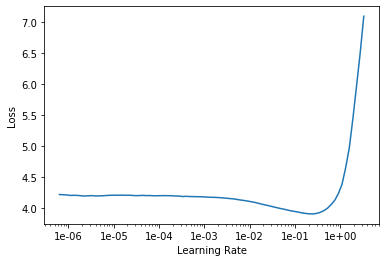

In [10]:
learn.recorder.plot()

In [13]:
learn.freeze()
learn.fit_one_cycle(4, slice(1e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,accuracy,time
0,2.791656,2.692023,0.613253,04:18
1,2.342813,2.264520,0.644867,04:19
2,2.193646,2.146392,0.654350,04:19
3,2.141188,2.128421,0.656149,04:19


Better model found at epoch 0 with valid_loss value: 2.692023277282715.
Better model found at epoch 1 with valid_loss value: 2.2645204067230225.
Better model found at epoch 2 with valid_loss value: 2.1463921070098877.
Better model found at epoch 3 with valid_loss value: 2.12842059135437.


In [14]:
learn.load('bestmodel')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (85436 items)
x: LMTextList
[ ' 
  xbos xfld 1 xxmaj eslinga xxmaj std xxmaj plana xxmaj amarilla xxmaj cs / 6 3 xxmaj tn x 2.5 xxmaj mts ' , ' 
  xbos xfld 1 xxmaj rodillera xxmaj con xxmaj barras xxmaj laterales , xxmaj unica xxmaj con xxmaj estabilizador ' , ' 
  xbos xfld 1 xxmaj batería xxmaj lth xxmaj jet xxmaj ski xxmaj arctic xxmaj cat xxmaj tiger xxmaj shark 2002 640cc ' ],[ ' 
  xbos xfld 1 xxmaj mecha xxmaj sds xxmaj plus xxmaj venturo _unk_ ' , ' 
  xbos xfld 1 xxmaj kit xxmaj reparo xxmaj parcial xxmaj trambulador xxmaj corsa xxmaj meriva xxmaj montana 02 / c / nf ' , ' 
  xbos xfld 1 xxmaj fertilizante xxmaj agrícola xxmaj nitrato xxmaj de xxmaj cálcio xxmaj yara 5 xxmaj kg . ' ],[ ' 
  xbos xfld 1 xxmaj pistola xxmaj pressão xxmaj beeman 2004 xxup p17 5,5 + xxmaj red xxmaj dot 1x30 + xxmaj case ' , ' 
  xbos xfld 1 xxmaj dois xxmaj _unk_ xxmaj usado xxmaj originais xxmaj sedex xxmaj grátis ' , ' 
  xbos xfld 1 xxmaj

In [15]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,accuracy,time
0,1.955294,1.967302,0.677285,05:45
1,1.785473,1.826272,0.695249,05:45
2,1.665948,1.752568,0.705098,05:45
3,1.603894,1.741379,0.707101,05:45


Better model found at epoch 0 with valid_loss value: 1.9673024415969849.
Better model found at epoch 1 with valid_loss value: 1.8262715339660645.
Better model found at epoch 2 with valid_loss value: 1.7525678873062134.
Better model found at epoch 3 with valid_loss value: 1.7413785457611084.


In [20]:
learn.load('bestmodel')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (85436 items)
x: LMTextList
[ ' 
  xbos xfld 1 xxmaj eslinga xxmaj std xxmaj plana xxmaj amarilla xxmaj cs / 6 3 xxmaj tn x 2.5 xxmaj mts ' , ' 
  xbos xfld 1 xxmaj rodillera xxmaj con xxmaj barras xxmaj laterales , xxmaj unica xxmaj con xxmaj estabilizador ' , ' 
  xbos xfld 1 xxmaj batería xxmaj lth xxmaj jet xxmaj ski xxmaj arctic xxmaj cat xxmaj tiger xxmaj shark 2002 640cc ' ],[ ' 
  xbos xfld 1 xxmaj mecha xxmaj sds xxmaj plus xxmaj venturo _unk_ ' , ' 
  xbos xfld 1 xxmaj kit xxmaj reparo xxmaj parcial xxmaj trambulador xxmaj corsa xxmaj meriva xxmaj montana 02 / c / nf ' , ' 
  xbos xfld 1 xxmaj fertilizante xxmaj agrícola xxmaj nitrato xxmaj de xxmaj cálcio xxmaj yara 5 xxmaj kg . ' ],[ ' 
  xbos xfld 1 xxmaj pistola xxmaj pressão xxmaj beeman 2004 xxup p17 5,5 + xxmaj red xxmaj dot 1x30 + xxmaj case ' , ' 
  xbos xfld 1 xxmaj dois xxmaj _unk_ xxmaj usado xxmaj originais xxmaj sedex xxmaj grátis ' , ' 
  xbos xfld 1 xxmaj

In [21]:
learn.validate()

[1.7436424, tensor(0.7070)]

In [17]:
learn.save_encoder('enc')

In [48]:
inputs = df_trn.iloc[:,df_names_to_idx(1, df)]

In [11]:
df_trn.iloc[51305]

0                                                    0
1    Cartucho Canon Cli-8 C - Cian, Inyección De Tinta
Name: 51305, dtype: object

In [18]:
data_clas = TextClasDataBunch.from_df(path,train_df=df_trn,valid_df=df_val,tokenizer=ttok,vocab=vocab)

In [22]:
learn = text_classifier_learner(data_clas, TransformerXL,drop_mult=0.3)
learn.load_encoder('enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


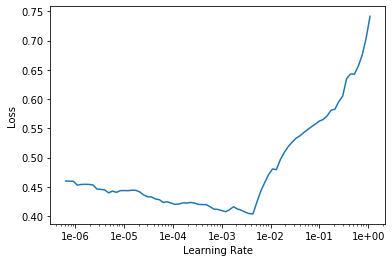

In [33]:
learn.recorder.plot()

In [37]:
learn = text_classifier_learner(data_clas, TransformerXL,drop_mult=0.3)

In [34]:
learn.fit_one_cycle(4, slice(1e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,accuracy,time
0,0.148362,0.147007,0.948938,05:07
1,0.117641,0.115243,0.957719,05:12
2,0.092766,0.105471,0.963062,05:11
3,0.091154,0.099518,0.964198,05:10


Better model found at epoch 0 with valid_loss value: 0.14700716733932495.
Better model found at epoch 1 with valid_loss value: 0.11524290591478348.
Better model found at epoch 2 with valid_loss value: 0.10547143965959549.
Better model found at epoch 3 with valid_loss value: 0.09951845556497574.


In [44]:
learn.load('bestmodel')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (250871 items)
x: TextList
_unk_ xxmaj eslinga xxmaj std xxmaj plana xxmaj amarilla xxmaj cs / 6 3 xxmaj tn x 2.5 xxmaj mts,_unk_ xxmaj rodillera xxmaj con xxmaj barras xxmaj laterales , xxmaj unica xxmaj con xxmaj estabilizador,_unk_ xxmaj batería xxmaj lth xxmaj jet xxmaj ski xxmaj arctic xxmaj cat xxmaj tiger xxmaj shark 2002 640cc,_unk_ xxmaj mecha xxmaj sds xxmaj plus xxmaj venturo _unk_,_unk_ xxmaj kit xxmaj reparo xxmaj parcial xxmaj trambulador xxmaj corsa xxmaj meriva xxmaj montana 02 / c / nf
y: CategoryList
0,0,1,0,0
Path: /home/ubuntu/fastai2/fastai/courses/dl2/imdb_scripts;

Valid: LabelList (32568 items)
x: TextList
_unk_ xxmaj _unk_ 150w xxmaj automático xxmaj _unk_ xxmaj preto xxmaj cigarro xxmaj isqueiro xxmaj ali,_unk_ xxmaj fita xxmaj dupla - face xxmaj de xxmaj papel xxmaj scotch ® 18mmx30 m,_unk_ 6 xxmaj multimassa xxmaj tedox 90 g xxmaj tapa xxmaj tudo xxmaj _unk_ xxmaj buraco xxmaj trinca xxmaj parede,_unk_ xxm

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-5,1e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,accuracy,time


In [42]:
learn.validate()

[0.102217995, tensor(0.9669)]